# Kaggle Marketing 🛍️

Тут будет описание

**Содержание**<a id='toc0_'></a>    
1. [Подготовка          ](#toc1_)    
1.1. [Библиотеки          ](#toc1_1_)    
1.2. [Конфигурация          ](#toc1_2_)    
1.3. [Сервисные функции          ](#toc1_3_)    
2. [Датасет `apparel-messages.csv`         ](#toc2_)    
2.1. [Загрузка         ](#toc2_1_)    
2.2. [Проверка типов данных         ](#toc2_2_)    
2.3. [Оптимизация памяти](#toc2_3_)    
2.4. [Проверка полных дубликатов         ](#toc2_4_)    
2.5. [Проверка пропусков         ](#toc2_5_)    
2.6. [Изучение признаков         ](#toc2_6_)    
2.6.1. [Описание признаков     ](#toc2_6_1_)    
2.6.2. [Признак `bulk_campaign_id`       ](#toc2_6_2_)    
2.6.3. [Признак `client_id`       ](#toc2_6_3_)    
2.6.4. [Признак `message_id`      ](#toc2_6_4_)    
2.6.5. [Признак `event`      ](#toc2_6_5_)    
2.6.6. [Признак `channel`     ](#toc2_6_6_)    
2.6.7. [Признак `date`     ](#toc2_6_7_)    
2.6.8. [Признак `created_at`    ](#toc2_6_8_)    
2.7. [Выводы по датасету    ](#toc2_7_)    
3. [Датасет `apparel-purchases.csv`        ](#toc3_)    
3.1. [Загрузка        ](#toc3_1_)    
3.2. [Проверка типов данных        ](#toc3_2_)    
3.3. [Оптимизация памяти](#toc3_3_)    
3.4. [Проверка полных дубликатов        ](#toc3_4_)    
3.5. [Проверка пропусков        ](#toc3_5_)    
3.6. [Изучение признаков ](#toc3_6_)    
3.6.1. [Описание признаков ](#toc3_6_1_)    
3.6.2. [Признак `client_id` ](#toc3_6_2_)    
3.6.3. [Признак `quantity` ](#toc3_6_3_)    
3.6.4. [Признак `price` ](#toc3_6_4_)    
3.6.5. [Признак `category_ids` ](#toc3_6_5_)    
3.6.6. [Признак `date` ](#toc3_6_6_)    
3.6.7. [Признак `message_id` ](#toc3_6_7_)    
3.7. [Выводы по датасету ](#toc3_7_)    
4. [Датасет `apparel-target_binary.csv`         ](#toc4_)    
4.1. [Проверка типов данных         ](#toc4_1_)    
4.2. [Оптимизация памяти](#toc4_2_)    
4.3. [Проверка полных дубликатов         ](#toc4_3_)    
4.4. [Проверка пропусков         ](#toc4_4_)    
4.5. [Изучение признаков         ](#toc4_5_)    
4.5.1. [Признак `client_id`         ](#toc4_5_1_)    
4.5.2. [Таргет `target`         ](#toc4_5_2_)    
4.6. [Выводы по датасету](#toc4_6_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=true
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## 1. <a id='toc1_'></a>Подготовка           [&#8593;](#toc0_)

### 1.1. <a id='toc1_1_'></a>Библиотеки           [&#8593;](#toc0_)

In [1]:
from IPython.display import clear_output

In [2]:
%pip install -r requirements.txt

clear_output()

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# Pipelines
from sklearn.pipeline import Pipeline
from sklearn.base import (BaseEstimator,
                          TransformerMixin)

# Preprocessing
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer

from sklearn.model_selection import train_test_split

# Metrics
from sklearn.metrics import (classification_report,
                             accuracy_score,
                             f1_score,
                             roc_auc_score)

from phik import phik_matrix  # this import IS accessed
from prettytable import PrettyTable
from termcolor import colored
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

### 1.2. <a id='toc1_2_'></a>Конфигурация           [&#8593;](#toc0_)

In [4]:
RANDOM_STATE = 27
TEST_SIZE = 0.20

pd.options.display.float_format = '{:.2f}'.format

import warnings
warnings.filterwarnings('ignore')

### 1.3. <a id='toc1_3_'></a>Сервисные функции           [&#8593;](#toc0_)

In [5]:
def optimize_memory_usage(df: pd.DataFrame, print_size: bool=True) -> pd.DataFrame:
    """Function optimizes memory usage in dataframe

    Args:
        df (pd.DataFrame): DataFrame to optimize.
        print_size (bool, optional): display of optimization results. Defaults to True.

    Returns:
        pd.DataFrame: optimized DataFrame
    """

    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64'] # Типы, которые будем проверять на оптимизацию

    # Размер занимаемой памяти до оптимизации (в Мб)
    before_size = df.memory_usage().sum() / 1024 ** 2

    for column in df.columns:
        column_type = df[column].dtypes
        if column_type in numerics:
            column_min = df[column].min()
            column_max = df[column].max()
            if str(column_type).startswith('int'):
                if column_min > np.iinfo(np.int8).min and column_max < np.iinfo(np.int8).max:
                    df[column] = df[column].astype(np.int8)
                elif column_min > np.iinfo(np.int16).min and column_max < np.iinfo(np.int16).max:
                    df[column] = df[column].astype(np.int16)
                elif column_min > np.iinfo(np.int32).min and column_max < np.iinfo(np.int32).max:
                    df[column] = df[column].astype(np.int32)
                elif column_min > np.iinfo(np.int64).min and column_max < np.iinfo(np.int64).max:
                    df[column] = df[column].astype(np.int64)
            else:
                if column_min > np.finfo(np.float32).min and column_max < np.finfo(np.float32).max:
                    df[column] = df[column].astype(np.float32)
                else:
                    df[column] = df[column].astype(np.float64)

    # Размер занимаемой памяти после оптимизации (в Мб)
    after_size = df.memory_usage().sum() / 1024 ** 2
    if print_size:
        print('Размер использования памяти: до {:5.2f} Mb - после {:5.2f} Mb ({:.1f}%)'
                            .format(before_size, after_size, 100 * (before_size - after_size) / before_size))
    return df

In [6]:
def check_duplicates(df: pd.DataFrame) -> None:
    duplicates_count = df.duplicated().sum()

    if duplicates_count == 0:
        print(colored('Полных дубликатов не обнаружено.', 'green'))
    else:
        duplicates_part = duplicates_count / len(df)
        print(colored(f'Обнаружено {duplicates_count} дубликатов ({duplicates_part:.2%})', 'red'))

In [7]:
def check_nans(data: pd.DataFrame) -> None:
    table = PrettyTable()
    table.field_names = ['Feature', 'Missing values count']

    missing_info = data.isna().sum().sort_values()
    cols = missing_info.index.to_list()
    for col in cols:
        count = missing_info[col]
        color = 'green' if count == 0 else 'red'
        s = f'{count} ({count / len(data):.2%})'
        table.add_row([col, colored(s, color)])

    print(table)

In [8]:
def check_nans_in_series(series: pd.Series) -> None:
    nan_cnt = series.isna().sum()
    text = colored('No missing values', 'green') if nan_cnt == 0 \
        else colored(f'{nan_cnt} ({nan_cnt / len(series):.2%})', 'red')
    print(text)

In [9]:
def get_value_counts(series: pd.Series) -> None:
    data = pd.DataFrame()
    data['count'] = series.value_counts()
    data['part'] =series.value_counts(normalize=True)
    display(data)

In [10]:
def plot_pie_chart(series: pd.Series) -> None:
    if not isinstance(series, pd.Series):
        raise ValueError('Входные данные должны быть объектом pd.Series')

    data = series.value_counts()

    plt.figure(figsize=(4, 4))
    data.plot.pie(labels=data.index, autopct='%1.1f%%', startangle=140)
    plt.ylabel('')
    plt.title('Распределение данных')
    plt.axis('equal')
    plt.tight_layout()
    plt.show()

In [11]:
def draw_plots_about_column(df: pd.DataFrame,
                            column: str,
                            column_description: str = None,
                            bins: int = 20
                            ) -> None:
    if column_description is None:
        column_description = column

    _, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))

    sns.violinplot(df, x=column, ax=ax1, orient='h')
    ax1.set_xlabel(column_description)
    ax1.grid()

    sns.boxplot(df, x=column, ax=ax2)
    ax2.set_xlabel(column_description)
    ax2.grid()

    sns.histplot(df, x=column, bins=bins, ax=ax3)
    ax3.set_xlabel(column_description)
    ax3.grid()
    ax3.set_ylabel('Количество')

    ax4.set_visible(False)

    plt.suptitle(f'Информация о колонке `{column_description}`', fontsize=18)
    plt.tight_layout()

    plt.show()

## 2. <a id='toc2_'></a>Датасет `apparel-messages.csv`          [&#8593;](#toc0_)

### 2.1. <a id='toc2_1_'></a>Загрузка          [&#8593;](#toc0_)

In [12]:
apparel_messages = pd.read_csv('./data/apparel-messages.csv', parse_dates=['date', 'created_at'])

In [13]:
apparel_messages.head()

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52


### 2.2. <a id='toc2_2_'></a>Проверка типов данных          [&#8593;](#toc0_)

In [14]:
apparel_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype         
---  ------            -----         
 0   bulk_campaign_id  int64         
 1   client_id         int64         
 2   message_id        object        
 3   event             object        
 4   channel           object        
 5   date              datetime64[ns]
 6   created_at        datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(3)
memory usage: 680.4+ MB


Типы данных корректны для всех признаков.

### 2.3. <a id='toc2_3_'></a>Оптимизация памяти [&#8593;](#toc0_)

In [15]:
apparel_messages = optimize_memory_usage(apparel_messages)

Размер использования памяти: до 680.38 Mb - после 607.48 Mb (10.7%)


### 2.4. <a id='toc2_4_'></a>Проверка полных дубликатов          [&#8593;](#toc0_)

In [16]:
check_duplicates(apparel_messages)

Обнаружено 48610 дубликатов (0.38%)


Обнаружены полные дубликаты, удалим их.

In [17]:
apparel_messages = apparel_messages.drop_duplicates()

In [18]:
check_duplicates(apparel_messages)

Полных дубликатов не обнаружено.


### 2.5. <a id='toc2_5_'></a>Проверка пропусков          [&#8593;](#toc0_)

In [19]:
check_nans(apparel_messages)

+------------------+----------------------+
|     Feature      | Missing values count |
+------------------+----------------------+
| bulk_campaign_id |      0 (0.00%)       |
|    client_id     |      0 (0.00%)       |
|    message_id    |      0 (0.00%)       |
|      event       |      0 (0.00%)       |
|     channel      |      0 (0.00%)       |
|       date       |      0 (0.00%)       |
|    created_at    |      0 (0.00%)       |
+------------------+----------------------+


Датасет не имеет пропущенных значений.

### 2.6. <a id='toc2_6_'></a>Изучение признаков          [&#8593;](#toc0_)

#### 2.6.1. <a id='toc2_6_1_'></a>Описание признаков      [&#8593;](#toc0_)

Датасет содержит данные о рассылках, которые были отправлены клиентам из таблицы покупок.

**Признаки:**
| Признак            | Описание                                                |
|:------------------:|---------------------------------------------------------|
| `bulk_campaign_id` | идентификатор рассылки                                  |
| `client_id`        | идентификатор клиента                                   |
| `message_id`       | идентификатор сообщения                                 |
| `event`            | действие с сообщением (отправлено, открыто, покупка...) |
| `channel`          | канал рассылки                                          |
| `date`             | дата действия                                           |
| `created_at`       | дата-время полностью                                    |

#### 2.6.2. <a id='toc2_6_2_'></a>Признак `bulk_campaign_id`        [&#8593;](#toc0_)

In [20]:
apparel_messages['bulk_campaign_id']

0            4439
1            4439
2            4439
3            4439
4            4439
            ...  
12739793    14657
12739794    14657
12739795    14641
12739796    14624
12739797    14641
Name: bulk_campaign_id, Length: 12691188, dtype: int16

In [21]:
apparel_messages['bulk_campaign_id'].nunique()

2709

Данный столбец является идентификатором рассылки и будет использован при объединении датасетов.

#### 2.6.3. <a id='toc2_6_3_'></a>Признак `client_id`        [&#8593;](#toc0_)

In [22]:
apparel_messages['client_id'].nunique()

53329

Это идентификатор клиента. Он также будет использоваться при объединении датасетов.

#### 2.6.4. <a id='toc2_6_4_'></a>Признак `message_id`       [&#8593;](#toc0_)

In [23]:
apparel_messages['message_id']

0            1515915625626736623-4439-6283415ac07ea
1            1515915625490086521-4439-62834150016dd
2            1515915625553578558-4439-6283415b36b4f
3            1515915625553578558-4439-6283415b36b4f
4            1515915625471518311-4439-628341570c133
                             ...                   
12739793    1515915625477497874-14657-65cdd371cc86c
12739794    1515915625765994334-14657-65cdd36018eac
12739795    1515915625545014677-14641-65cb2434b25a1
12739796    1515915625477497874-14624-65c5e22fb401e
12739797    1515915625477497874-14641-65cb249172d68
Name: message_id, Length: 12691188, dtype: object

In [24]:
apparel_messages['message_id'].nunique(), len(apparel_messages)

(9061667, 12691188)

Данный столбец является идентификатор сообщения.

#### 2.6.5. <a id='toc2_6_5_'></a>Признак `event`       [&#8593;](#toc0_)

In [25]:
apparel_messages['event']

0            open
1            open
2            open
3           click
4            open
            ...  
12739793     open
12739794     open
12739795     open
12739796     open
12739797     open
Name: event, Length: 12691188, dtype: object

In [26]:
apparel_messages['event'].nunique()

11

In [27]:
get_value_counts(apparel_messages['event'])

,count,part
event,,
send,9058174,0.71
open,3052481,0.24
click,483326,0.04
purchase,62593,0.00
hard_bounce,19763,0.00
soft_bounce,10582,0.00
unsubscribe,2833,0.00
hbq_spam,823,0.00
complain,527,0.00


#### 2.6.6. <a id='toc2_6_6_'></a>Признак `channel`      [&#8593;](#toc0_)

In [28]:
apparel_messages['channel']

0           email
1           email
2           email
3           email
4           email
            ...  
12739793    email
12739794    email
12739795    email
12739796    email
12739797    email
Name: channel, Length: 12691188, dtype: object

In [29]:
apparel_messages['channel'].nunique()

2

In [30]:
get_value_counts(apparel_messages['channel'])

,count,part
channel,,
mobile_push,7470472,0.59
email,5220716,0.41


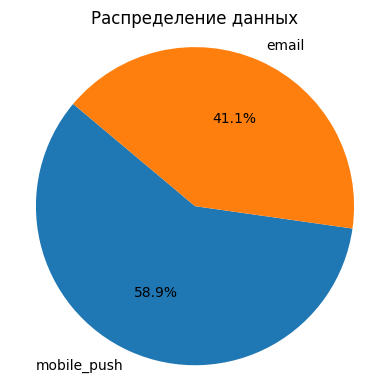

In [31]:
plot_pie_chart(apparel_messages['channel'])

#### 2.6.7. <a id='toc2_6_7_'></a>Признак `date`      [&#8593;](#toc0_)

In [32]:
apparel_messages['date']

0          2022-05-19
1          2022-05-19
2          2022-05-19
3          2022-05-19
4          2022-05-19
              ...    
12739793   2024-02-15
12739794   2024-02-15
12739795   2024-02-15
12739796   2024-02-15
12739797   2024-02-15
Name: date, Length: 12691188, dtype: datetime64[ns]

In [33]:
apparel_messages['date'].describe()

count                         12691188
mean     2023-06-04 17:27:00.569989632
min                2022-05-19 00:00:00
25%                2022-12-16 00:00:00
50%                2023-07-20 00:00:00
75%                2023-11-21 00:00:00
max                2024-02-15 00:00:00
Name: date, dtype: object

Все даты адекватны.

#### 2.6.8. <a id='toc2_6_8_'></a>Признак `created_at`     [&#8593;](#toc0_)

In [34]:
apparel_messages['created_at']

0          2022-05-19 00:14:20
1          2022-05-19 00:39:34
2          2022-05-19 00:51:49
3          2022-05-19 00:52:20
4          2022-05-19 00:56:52
                   ...        
12739793   2024-02-15 23:51:40
12739794   2024-02-15 23:52:20
12739795   2024-02-15 23:52:40
12739796   2024-02-15 23:58:40
12739797   2024-02-15 23:58:40
Name: created_at, Length: 12691188, dtype: datetime64[ns]

In [67]:
apparel_messages['created_at'].describe()

count                         12691188
mean     2023-06-05 04:38:55.658559232
min                2022-05-19 00:14:20
25%                2022-12-16 19:15:55
50%                2023-07-20 11:09:42
75%                2023-11-21 15:58:05
max                2024-02-15 23:58:40
Name: created_at, dtype: object

Все даты адекватны.

In [35]:
mask = (apparel_messages['date'].dt.year != apparel_messages['created_at'].dt.year) | \
       (apparel_messages['date'].dt.month != apparel_messages['created_at'].dt.month) | \
       (apparel_messages['date'].dt.day != apparel_messages['created_at'].dt.day)
mask.sum()

0

Признак `created_at` содержит более полную информацию о дате рассылки, чем `date`, так содержит те же самые даты, но еще и время. По сути признак `created_at` включает в себя информацию столбца `date`, следовательно последний может быть удален.

In [36]:
shape_before = apparel_messages.shape
apparel_messages = apparel_messages.drop(columns='date')

assert apparel_messages.shape[0] == shape_before[0], 'Количество строк ДО и ПОСЛЕ удаления не совпадает.'
assert 'date' not in apparel_messages.columns, 'Признак не был удален.'
assert apparel_messages.shape[1] == shape_before[1] - 1, 'Количество признаков не совпадает с ожидаемым.'

### 2.7. <a id='toc2_7_'></a>Выводы по датасету     [&#8593;](#toc0_)

Датасет содержит данные о рассылках, которые были отправлены клиентам из таблицы покупок. Содержит несколько id (`client_id`, `message_id`), которые будут использованы для объединения с другими таблицами.

Пропусков в датасете нет, полные дубликаты были обнаружены (`48610 (0.38%)`) и удалены.

Было замечено, что признак `created_at` содержит более полную информацию о дате рассылки, чем `date`, так содержит те же самые даты, но еще время. По сути признак `created_at` включает в себя информацию столбца `date`. Поэтому признак `date` был удален.

## 3. <a id='toc3_'></a>Датасет `apparel-purchases.csv`         [&#8593;](#toc0_)

### 3.1. <a id='toc3_1_'></a>Загрузка         [&#8593;](#toc0_)

In [37]:
apparel_purchases = pd.read_csv('./data/apparel-purchases.csv', parse_dates=['date'])

In [38]:
apparel_purchases.head()

,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,1999.00,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,2499.00,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,6499.00,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843
3,1515915625471138230,1,4999.00,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843
4,1515915625471138230,1,4999.00,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843


### 3.2. <a id='toc3_2_'></a>Проверка типов данных         [&#8593;](#toc0_)

In [39]:
apparel_purchases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   client_id     202208 non-null  int64         
 1   quantity      202208 non-null  int64         
 2   price         202208 non-null  float64       
 3   category_ids  202208 non-null  object        
 4   date          202208 non-null  datetime64[ns]
 5   message_id    202208 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 9.3+ MB


Типы данных во всех признаках корректны.

### 3.3. <a id='toc3_3_'></a>Оптимизация памяти [&#8593;](#toc0_)

In [40]:
apparel_purchases = optimize_memory_usage(apparel_purchases)

Размер использования памяти: до  9.26 Mb - после  7.14 Mb (22.9%)


### 3.4. <a id='toc3_4_'></a>Проверка полных дубликатов         [&#8593;](#toc0_)

In [41]:
check_duplicates(apparel_purchases)

Обнаружено 73020 дубликатов (36.11%)


Обнаружено довольно большое количество полных дубликатов (больше `36%`). Это выглядит довольно странно.

Что значит, что строки полные дубликаты между собой? Что пользователь купил в один день один по одной рассылке товары с одной ценой из одной категории. Скорее всего это значит, что пользователь купил разные вкусы или оформил один и тот же товар разными заказами. Например, купил товар, подумал, что надо бы еще купить сразу прозапас. И вновь купил этот же товар.

Поэтому самым логичным решением кажется сгруппировать эти строки, просуммировав признак `quantity`.

In [42]:
other_columns = apparel_purchases.columns.difference(['quantity']).tolist()
apparel_purchases = apparel_purchases.groupby(other_columns, as_index=False).agg({'quantity': 'sum'})

In [43]:
check_duplicates(apparel_purchases)

Полных дубликатов не обнаружено.


После преобразований полных дубликатов нет.

### 3.5. <a id='toc3_5_'></a>Проверка пропусков         [&#8593;](#toc0_)

In [44]:
check_nans(apparel_purchases)

+--------------+----------------------+
|   Feature    | Missing values count |
+--------------+----------------------+
| category_ids |      0 (0.00%)       |
|  client_id   |      0 (0.00%)       |
|     date     |      0 (0.00%)       |
|  message_id  |      0 (0.00%)       |
|    price     |      0 (0.00%)       |
|   quantity   |      0 (0.00%)       |
+--------------+----------------------+


Пропусков в датасете нет.

### 3.6. <a id='toc3_6_'></a>Изучение признаков  [&#8593;](#toc0_)

#### 3.6.1. <a id='toc3_6_1_'></a>Описание признаков  [&#8593;](#toc0_)

Данные о покупках клиентов по дням и по товарам. В каждой записи покупка определенного товара, его цена, количество штук.

В таблице есть списки идентификаторов, к каким категориям относится товар. Часто это вложенные категории (например, автотовары-аксессуары-освежители), но также может включать в начале списка маркер распродажи или маркер женщинам/мужчинам.

Нумерация категорий сквозная для всех уровней, то есть 44 на второй позиции списка или на третьей – это одна и та же категория. Иногда дерево категорий обновляется, поэтому могут меняться вложенности, например ['4', '28', '44', '1594'] или ['4', '44', '1594'].

**Признаки:**
|     Признак    | Описание                            |
|:--------------:|-------------------------------------|
|   `client_id`  | идентификатор клиента               |
|   `quantity`   | количество единиц товара            |
|     `price`    | цена товара                         |
| `category_ids` | идентификаторы категорий            |
|     `date`     | дата покупки                        |
|  `message_id`  | идентификатор сообщения из рассылки |

#### 3.6.2. <a id='toc3_6_2_'></a>Признак `client_id`  [&#8593;](#toc0_)

In [45]:
apparel_purchases['client_id']

0         1515915625489044168
1         1515915625789566616
2         1515915625666901395
3         1515915625468069875
4         1515915625468124765
                 ...         
129013    1515915626009515678
129014    1515915626009608336
129015    1515915626009661190
129016    1515915626009681249
129017    1515915626010183608
Name: client_id, Length: 129018, dtype: int64

Данный столбец содержит идентификаторы клиентов и может быть использован при объединении таблиц.

#### 3.6.3. <a id='toc3_6_3_'></a>Признак `quantity`  [&#8593;](#toc0_)

In [46]:
apparel_purchases['quantity']

0         1
1         1
2         1
3         1
4         1
         ..
129013    2
129014    2
129015    2
129016    2
129017    2
Name: quantity, Length: 129018, dtype: int8

In [47]:
apparel_purchases['quantity'].nunique()

35

In [48]:
apparel_purchases['quantity'].describe()

count   129018.00
mean         1.58
std          0.99
min          1.00
25%          1.00
50%          1.00
75%          2.00
max         96.00
Name: quantity, dtype: float64

In [49]:
get_value_counts(apparel_purchases['quantity'])

,count,part
quantity,,
1,69620,0.54
2,52277,0.41
4,3038,0.02
3,2930,0.02
6,508,0.00
5,312,0.00
8,87,0.00
7,69,0.00
10,44,0.00


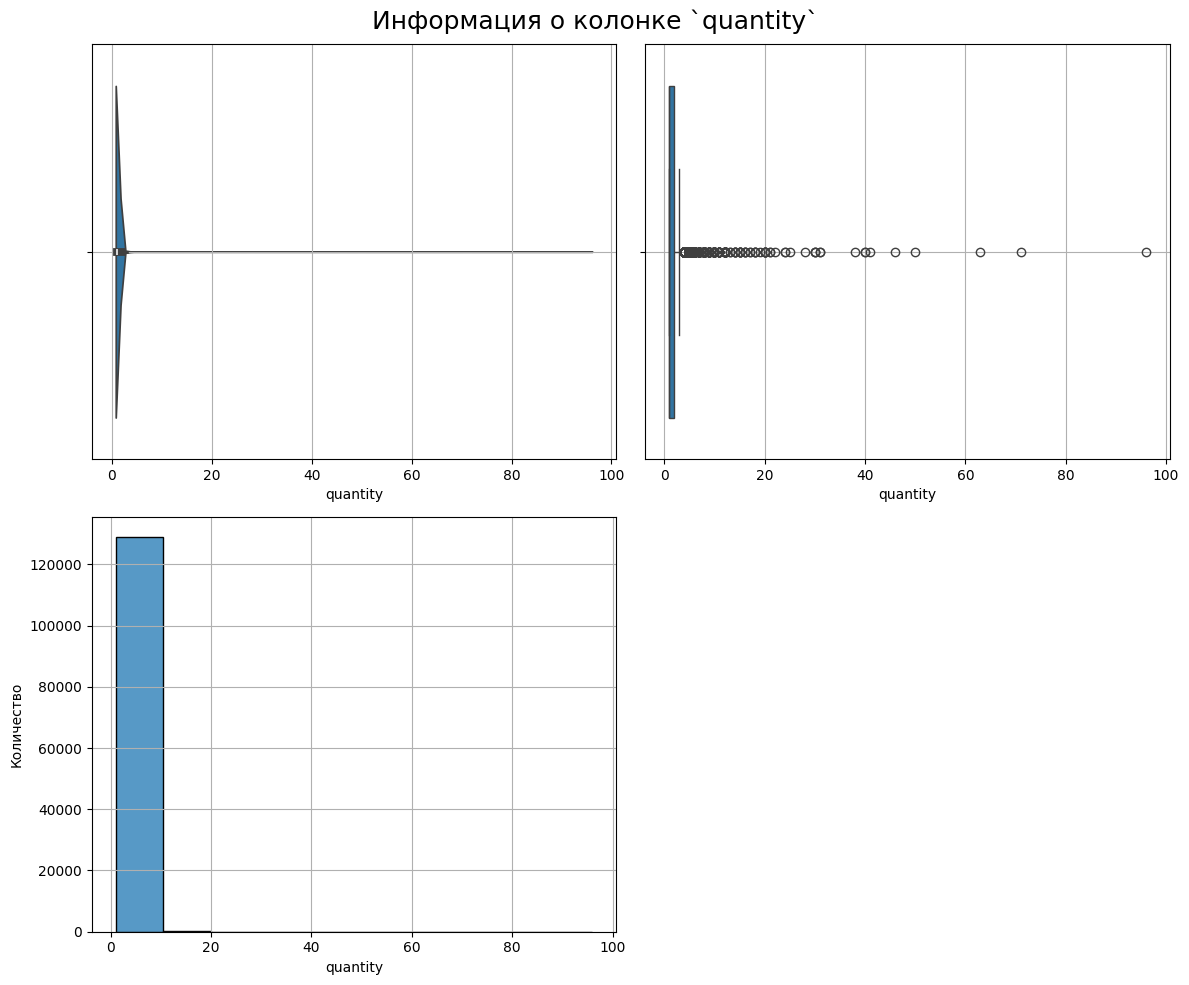

In [70]:
draw_plots_about_column(apparel_purchases, 'quantity', bins=10)

#### 3.6.4. <a id='toc3_6_4_'></a>Признак `price`  [&#8593;](#toc0_)

In [50]:
apparel_purchases['price']

0        1799.00
1        1799.00
2         199.00
3         999.00
4         999.00
           ...  
129013      7.00
129014      7.00
129015      5.00
129016      7.00
129017      5.00
Name: price, Length: 129018, dtype: float32

In [51]:
apparel_purchases['price'].describe()

count   129018.00
mean      1264.69
std       1375.35
min          1.00
25%        399.00
50%        999.00
75%       1750.00
max      85499.00
Name: price, dtype: float64

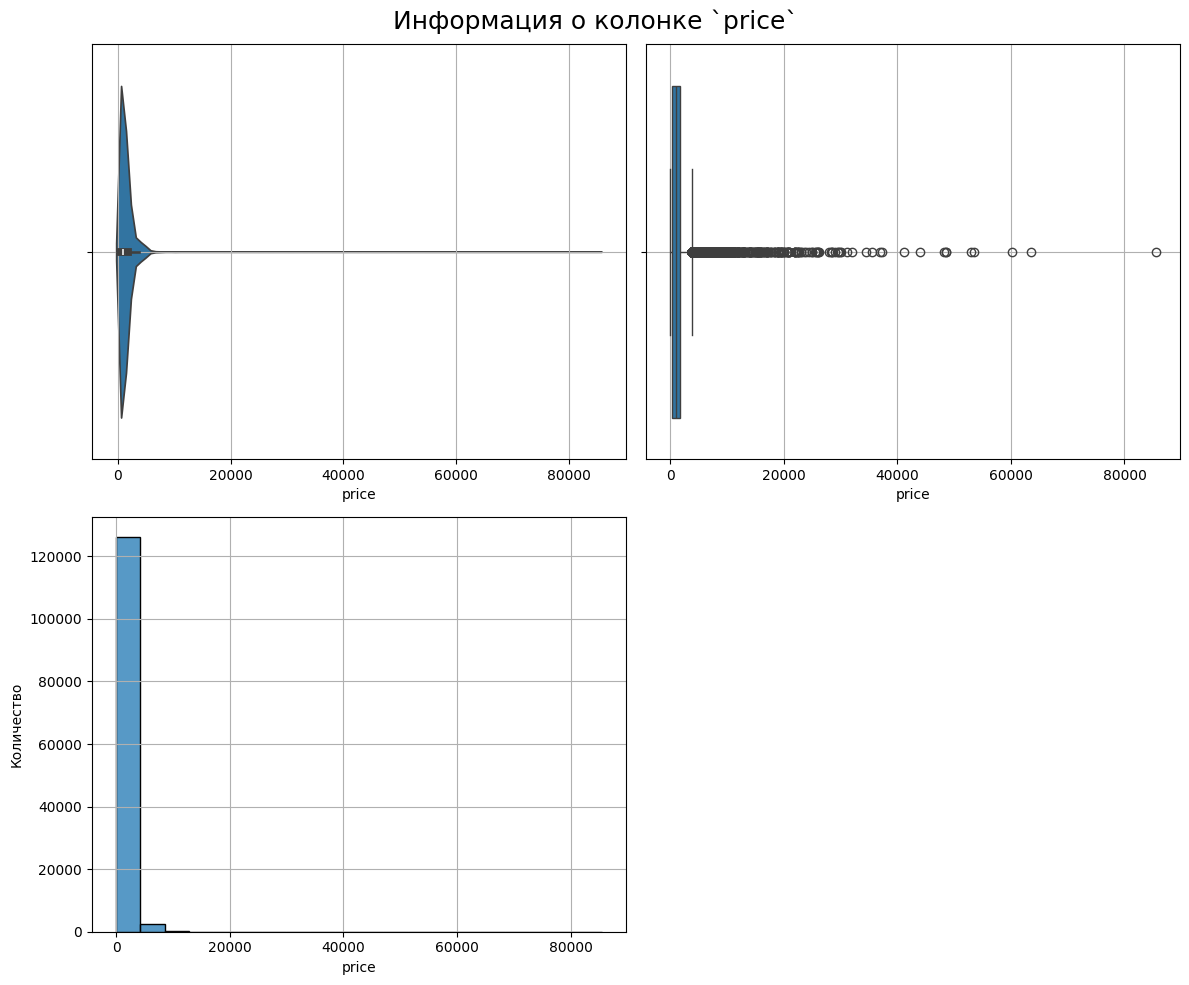

In [52]:
draw_plots_about_column(apparel_purchases, 'price')

#### 3.6.5. <a id='toc3_6_5_'></a>Признак `category_ids`  [&#8593;](#toc0_)

In [71]:
apparel_purchases['category_ids']

0          ['1', '22', '50', '685']
1          ['1', '22', '50', '685']
2          ['1', '8', '280', '710']
3         ['2', '17', '107', '453']
4         ['2', '17', '107', '453']
                    ...            
129013                           []
129014                           []
129015                           []
129016                           []
129017                           []
Name: category_ids, Length: 129018, dtype: object

Сразу заметим, что есть часть товаров вообще без категорий.

In [72]:
apparel_purchases['category_ids'].nunique()

933

Довольно большое количество уникальных сочетаний.

В задании было указано, что

> Иногда дерево категорий обновляется, поэтому могут меняться вложенности, например ['4', '28', '44', '1594'] или ['4', '44', '1594']. Как обработать такие случаи – можете предлагать свои варианты решения.

#### 3.6.6. <a id='toc3_6_6_'></a>Признак `date`  [&#8593;](#toc0_)

In [53]:
apparel_purchases['date']

0        2022-07-12
1        2022-08-07
2        2022-06-01
3        2022-07-09
4        2022-07-08
            ...    
129013   2024-02-03
129014   2024-02-06
129015   2024-02-07
129016   2024-02-05
129017   2024-02-13
Name: date, Length: 129018, dtype: datetime64[ns]

In [54]:
apparel_purchases['date'].describe()

count                           129018
mean     2023-02-26 10:13:27.292005632
min                2022-05-16 00:00:00
25%                2022-09-09 00:00:00
50%                2023-03-22 00:00:00
75%                2023-06-28 00:00:00
max                2024-02-16 00:00:00
Name: date, dtype: object

Все даты адекватны.

#### 3.6.7. <a id='toc3_6_7_'></a>Признак `message_id`  [&#8593;](#toc0_)

In [55]:
apparel_purchases['message_id']

0          1515915625489044168-5335-62c7d2d6bd056
1          1515915625789566616-5785-62ecc38c85606
2          1515915625666901395-4698-62971583c7270
3          1515915625487285028-5335-62c7d2b9eef22
4          1515915625468124765-5335-62c7d2d245db8
                           ...                   
129013    1515915625776547382-14587-65bcc2a78a468
129014    1515915626009608336-14594-65c0879eaf1ec
129015    1515915626009661190-14600-65c1e75b31a21
129016    1515915625558930991-14595-65c085673111d
129017    1515915625489302721-14623-65c5c5804cb67
Name: message_id, Length: 129018, dtype: object

Значения в данном столбце состоят из 3 частей: id клиента (`client_id`), id рекламной компании (`bulk_campaign_id`) и (как я понимаю) непосредственно id сообщения.

### 3.7. <a id='toc3_7_'></a>Выводы по датасету  [&#8593;](#toc0_)

## 4. <a id='toc4_'></a>Датасет `apparel-target_binary.csv`          [&#8593;](#toc0_)

In [56]:
apparel_target_binary = pd.read_csv('./data/apparel-target_binary.csv')

In [57]:
apparel_target_binary.head()

,client_id,target
0,1515915625468060902,0
1,1515915625468061003,1
2,1515915625468061099,0
3,1515915625468061100,0
4,1515915625468061170,0


### 4.1. <a id='toc4_1_'></a>Проверка типов данных          [&#8593;](#toc0_)

In [58]:
apparel_target_binary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   client_id  49849 non-null  int64
 1   target     49849 non-null  int64
dtypes: int64(2)
memory usage: 779.0 KB


Все столбцы имеют верные типы данных.

### 4.2. <a id='toc4_2_'></a>Оптимизация памяти [&#8593;](#toc0_)

In [59]:
apparel_target_binary = optimize_memory_usage(apparel_target_binary)

Размер использования памяти: до  0.76 Mb - после  0.43 Mb (43.7%)


### 4.3. <a id='toc4_3_'></a>Проверка полных дубликатов          [&#8593;](#toc0_)

In [60]:
check_duplicates(apparel_target_binary)

Полных дубликатов не обнаружено.


### 4.4. <a id='toc4_4_'></a>Проверка пропусков          [&#8593;](#toc0_)

In [61]:
check_nans(apparel_target_binary)

+-----------+----------------------+
|  Feature  | Missing values count |
+-----------+----------------------+
| client_id |      0 (0.00%)       |
|   target  |      0 (0.00%)       |
+-----------+----------------------+


Пропусков в датасете нет.

### 4.5. <a id='toc4_5_'></a>Изучение признаков          [&#8593;](#toc0_)

#### 4.5.1. <a id='toc4_5_1_'></a>Признак `client_id`          [&#8593;](#toc0_)

In [62]:
apparel_target_binary['client_id']

0        1515915625468060902
1        1515915625468061003
2        1515915625468061099
3        1515915625468061100
4        1515915625468061170
                ...         
49844    1515915626010261344
49845    1515915626010266132
49846    1515915626010439406
49847    1515915626010443527
49848    1515915626010443624
Name: client_id, Length: 49849, dtype: int64

In [63]:
apparel_target_binary['client_id'].nunique(), len(apparel_target_binary)

(49849, 49849)

Абсолютно все id уникальны.

#### 4.5.2. <a id='toc4_5_2_'></a>Таргет `target`          [&#8593;](#toc0_)

In [64]:
get_value_counts(apparel_target_binary['target'])

,count,part
target,,
0,48888,0.98
1,961,0.02


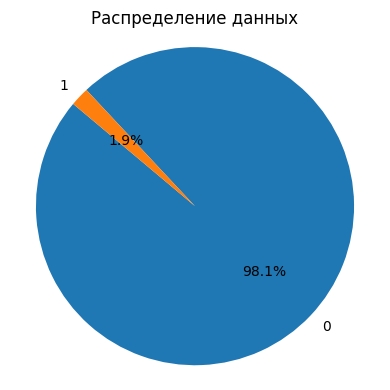

In [65]:
plot_pie_chart(apparel_target_binary['target'])

Видим крайне сильный дизбаланс в сторону класса `0`.

### 4.6. <a id='toc4_6_'></a>Выводы по датасету [&#8593;](#toc0_)

Датасет содержит информацию о целевом признаке - совершил ли клиент покупку в целевом периоде.

В датасете всего 2 столбца:
- `client_id` - идентификатор клиента, который будет использован для объединения таблиц
- `target` - целевой признак

Пропусков в датасете нет, полные дубликаты не обнаружены.

## Объединение таблиц

Объединим таблицы в один датафрейм.

In [66]:
df = pd.merge()

TypeError: merge() missing 2 required positional arguments: 'left' and 'right'